In [45]:
# imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.feature_selection import SelectKBest, chi2

import plotly as ply
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib notebook

#os.environ['KERAS_BACKEND'] = 'tensorflow'
from tensorflow.keras import backend as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *


pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 80)

In [46]:
## Data Pre-Processing
#### We load in individual csv files collected from Rosbag on TurtleBot3 with ROS.

In [47]:
dataFolder = r"C:\Users\jaker\Documents\Experiment3Data-2019-11-21"

dataFiles = [
    r"gMitTile_s15_t8.csv",
    r"gMitTile_s15_t9.csv",
    r"gMitTile_s15_t10.csv",
    r"gTurf_s15_t3.csv",
    r"gTurf_s15_t4.csv",
    r"gTurf_s15_t5.csv",
    r"gTurf_s15_t6.csv",
    r"gTurf_s15_t7.csv",
    r"gTurf_s15_t8.csv",
    r"gTurf_s15_t9.csv",
    r"gTurf_s15_t10.csv",
    r"gArcTile_s15_t3.csv",
    r"gArcTile_s15_t4.csv",
    r"gArcTile_s15_t5.csv",
    r"gArcTile_s15_t6.csv",
    r"gArcTile_s15_t7.csv",
    r"gArcTile_s15_t8.csv",
    r"gArcTile_s15_t9.csv",
    r"gArcTile_s15_t10.csv",
    r"gCarp_s15_t3.csv",
    r"gCarp_s15_t4.csv",
    r"gCarp_s15_t5.csv",
    r"gCarp_s15_t6.csv",
    r"gCarp_s15_t7.csv",
    r"gCarp_s15_t8.csv",
    r"gCarp_s15_t9.csv",
    r"gCarp_s15_t10.csv",
    r"gMitTile_s15_t3.csv",
    r"gMitTile_s15_t4.csv",
    r"gMitTile_s15_t5.csv",
    r"gMitTile_s15_t6.csv",
    r"gMitTile_s15_t7.csv"
]

savePath = "Data-32Series-Delta30-Squared.csv"

In [48]:
""" 
For each data file we:
adjust the index, 
interpolate NaN values,
drop remaining NaN values, 
drop some empty columns.

We then augment the feature space with delta columns, 
and with polynomial columns,
and label the columns with terrain, speed, and trial number


"""

trials=[]

for i in range(len(dataFiles)):
    terrain = dataFiles[i].split('_')[0][1:]
    speed = dataFiles[i].split('_s')[1][:2]
    trial = dataFiles[i].split('_t')[1][0:2].strip('.')
    

    df = pd.read_csv(os.path.join(dataFolder, dataFiles[i]))
    df = df.rename(columns={'Unnamed: 0': 'Seq'})
    df = df.set_index('Seq')

    df = df.interpolate(method='polynomial', order=1)

    df = df.dropna()
    df = df.reset_index().drop(columns=['Seq'])

    df = df.drop(columns=['OdomPosZ', 'OdomOrientX', 'OdomOrientY', 'OdomLinY', 'OdomLinZ', 'OdomAngX', 'OdomAngY'])
    df['OdomPosXY'] = np.sqrt(df.OdomPosX**2 + df.OdomPosY**2)
    df = df.drop(columns=['OdomPosY', 'OdomPosX'])
    
    df = df.reset_index().drop(columns=['index'])
    df = df.drop(columns=['Sensor', 'Time'])
    
    origLength = df.shape[0]

    sampleSize = 16
    
    length = origLength - origLength%sampleSize
    df = df.iloc[:length]
    
    numShifts = 4 # we split into sections with overlap 
    
    shiftArrays = []
    for x in range(numShifts):
        shiftArrays.append(np.roll(df.to_numpy(), sampleSize//numShifts*x, axis=0))
    
    dfArray = np.concatenate(shiftArrays)
    
    numSamples = length//sampleSize*numShifts
    
    samples = np.array(np.array_split(dfArray, numSamples, axis=0))
    
    terrLabel = ['Carp', 'Turf', 'ArcTile', 'MitTile'].index(terrain)
    label = np.zeros(4)
    label[terrLabel] = 1.0
    labels = np.array([label for x in range(len(samples))])
    
    if i==0:
        xSamples = np.array(np.copy(samples))
        yLabels = np.array(np.copy(labels))
    else:
        xSamples = np.concatenate((xSamples, samples))
        yLabels = np.concatenate((yLabels, labels))
        
    trials = trials + [int(trial)]*samples.shape[0]
    
    print("From dataframe with length {} we added: ".format(origLength))                             
    print("Added {} samples of size {} by {} of class:".format(samples.shape[0], samples.shape[1],samples.shape[2]))
    print(label)
    


From dataframe with length 3831 we added: 
Added 956 samples of size 16 by 15 of class:
[0. 0. 0. 1.]
From dataframe with length 4331 we added: 
Added 1080 samples of size 16 by 15 of class:
[0. 0. 0. 1.]
From dataframe with length 4853 we added: 
Added 1212 samples of size 16 by 15 of class:
[0. 0. 0. 1.]
From dataframe with length 6101 we added: 
Added 1524 samples of size 16 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 5840 we added: 
Added 1460 samples of size 16 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 3352 we added: 
Added 836 samples of size 16 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 5253 we added: 
Added 1312 samples of size 16 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 5251 we added: 
Added 1312 samples of size 16 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 6668 we added: 
Added 1664 samples of size 16 by 15 of class:
[0. 1. 0. 0.]
From dataframe with length 5075 we added: 
Added 1268 samples of size 16 by

In [49]:
xSamples = xSamples.astype('float64')
yLabels = yLabels.astype('float64')

In [50]:
yLabels.shape

(38692, 4)

In [51]:
xSamples.shape

(38692, 16, 15)

In [52]:
#X_train, X_test, Y_train, Y_test = train_test_split(xSamples, yLabels, test_size=0.2, shuffle=True)

In [58]:
X_train = np.array([xSamples[x] for x in range(xSamples.shape[0]) if trials[x]<9 ])
Y_train = np.array([yLabels[x] for x in range(yLabels.shape[0]) if trials[x]<9 ])

In [59]:
X_test = np.array([xSamples[x] for x in range(xSamples.shape[0]) if trials[x]>=9 ])
Y_test = np.array([yLabels[x] for x in range(yLabels.shape[0]) if trials[x]>=9 ])

In [62]:
X_test.shape

(11424, 16, 15)

In [63]:
verbose, epochs, batch_size = 1, 10, 16
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

In [64]:
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               46400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
Total params: 56,904
Trainable params: 56,904
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=verbose)

Train on 27268 samples, validate on 11424 samples
Epoch 1/10
27268/27268 [==============================] - 16s 577us/sample - loss: 0.4153 - accuracy: 0.7966 - val_loss: 4.5642 - val_accuracy: 0.2653
Epoch 2/10
27268/27268 [==============================] - 12s 456us/sample - loss: 0.2742 - accuracy: 0.8660 - val_loss: 5.4564 - val_accuracy: 0.2947
Epoch 3/10
27268/27268 [==============================] - 13s 466us/sample - loss: 0.2280 - accuracy: 0.8929 - val_loss: 5.8015 - val_accuracy: 0.2862
Epoch 4/10
27268/27268 [==============================] - 13s 460us/sample - loss: 0.1268 - accuracy: 0.9487 - val_loss: 5.7995 - val_accuracy: 0.3268
Epoch 5/10
27268/27268 [==============================] - 13s 463us/sample - loss: 0.0422 - accuracy: 0.9856 - val_loss: 4.6445 - val_accuracy: 0.3653
Epoch 6/10
27268/27268 [==============================] - 13s 465us/sample - loss: 0.0548 - accuracy: 0.9788 - val_loss: 3.2260 - val_accuracy: 0.5561
Epoch 7/10
27268/27268 [====================

In [66]:
_, accuracy =  model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)

In [67]:
accuracy

0.39206934

<IPython.core.display.Javascript object>


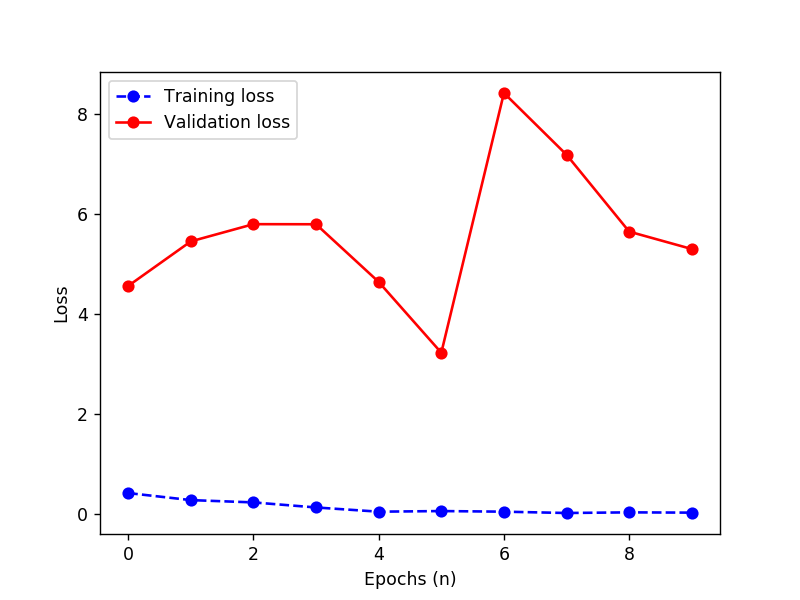

In [68]:
# graphical results
plt.figure()
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

<IPython.core.display.Javascript object>


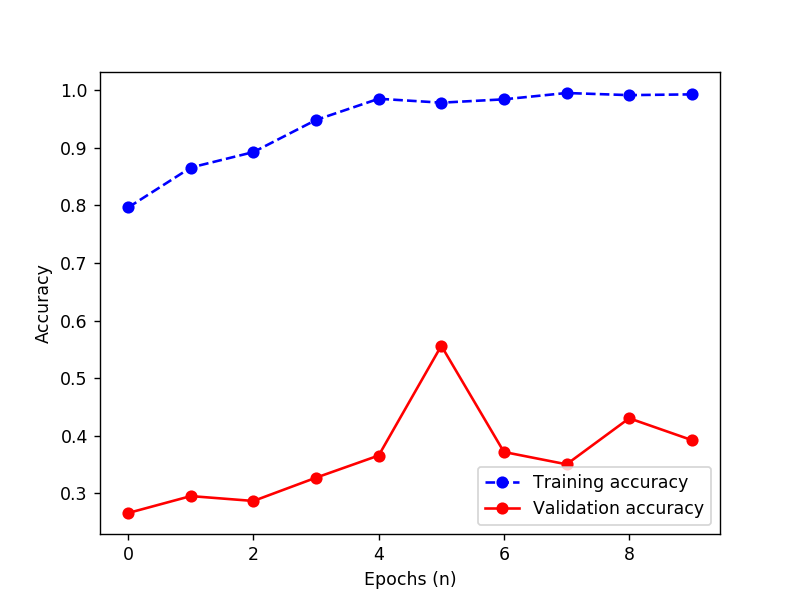

In [69]:
plt.figure()
plt.plot(history.history['accuracy'], 'bo--')
plt.plot(history.history['val_accuracy'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()